### KOSPI200

다음과 같은 이유로 KODEX200 ETF(069500)을 선정함
- 거래량이 2024년 3월 기준 평균 650만주가 거래되어, 일평균 거래량 25.6만건인 KOSPI200 선물에 비해 많은 거래량을 보여줌
- 시총 7.5조원 규모의 ETF상품

In [4]:
import yfinance as yf
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

start_date = '2014-01-01'
end_date = '2024-03-26'
ticker = '069500'

data = pdr.DataReader(ticker, 'naver', start=start_date, end=end_date).astype(float)
data.index = pd.to_datetime(data.index)

In [5]:
data['Returns'] = data['Close'].pct_change()
data['Cumulative Returns'] = (1 + data['Returns']).cumprod() - 1

days = [i for i in range(3, 62, 2)]
threshold = tuple([-i * 0.01 for i in range(3, 21)])

items = [(i, j) for i in days for j in threshold]

return_data = pd.DataFrame(index = data.index)

for i in range(1, 501) :
    return_data['-' + str(i) + 'days'] = (data['Close'] - data['Close'].shift(i)) / data['Close']

return_data.to_csv('KOSPI_returns_data.csv')
return_data.to_excel('KOSPI_returns_data.xlsx')

In [6]:
return_data.index = range(len(return_data))

In [7]:
dataframes = dict()
dataframes_plot = dict()

for d, thres in tqdm(items) :
    thres = round(-thres * 100, 1)
    dataframes[f'day{d}_{thres}per'] = pd.DataFrame(index = data.index)
    dataframes_plot[f'day{d}_{thres}per_plot'] = pd.DataFrame(index = data.index)
    for i in range(1, 501) :
        temp = ((1 + data['Cumulative Returns'].iloc[return_data[return_data[str(-i) + 'days'] < -thres * 0.01][:-d].index + d]) / (1 + data['Cumulative Returns'].iloc[return_data[return_data[str(-i) + 'days'] < -thres * 0.01][:-d].index].values)) - 1
        dataframes[f'day{d}_{thres}per'] = pd.concat(
            [dataframes[f'day{d}_{thres}per'], temp], axis = 1
        )
        dataframes_plot[f'day{d}_{thres}per_plot'] = pd.concat(
            [dataframes_plot[f'day{d}_{thres}per_plot'], temp], axis = 0
        )
    dataframes[f'day{d}_{thres}per'].columns = [str(-i) + 'days' for i in range(1, 501)]
    dataframes[f'day{d}_{thres}per'].to_excel(f'./excel/KOSPI_day{d}_{int(thres)}per.xlsx')

100%|██████████| 540/540 [2:23:50<00:00, 15.98s/it]  


In [8]:
import pickle

with open('kospi200.pkl', 'wb') as f:
    pickle.dump(dataframes, f)

In [288]:
for d, thres in tqdm(items) :
    thres = round(-thres * 100, 1)
    path = f'./parquet/KOSPI_day{d}_{int(thres)}per.parquet'
    dataframes[f'day{d}_{thres}per'].to_parquet(path)

100%|██████████| 540/540 [00:34<00:00, 15.80it/s]


In [9]:
def statsplot(index, data, thresh, ticker : str) :
    plt.figure(figsize = (8, 8))
    plt.subplot(2, 2, 1)
    plt.plot(
        index, [i.mean() for i in data],
        marker = '.'
    )
    plt.grid(False)
    #plt.ylim([-0.05, 0.25])
    plt.axhline(0, color = 'gray', alpha = 0.75, ls = '-.')
    plt.title('mean')
    
    plt.subplot(2, 2, 2)
    plt.plot(
        index, [i.std() for i in data],
        marker = '.'
    )
    plt.grid(False)
    #plt.ylim([-0.05, 0.2])
    plt.axhline(0, color = 'gray', alpha = 0.75, ls = '-.')
    plt.title('standard dev')
    
    plt.subplot(2, 2, 3)
    plt.plot(
        index, [i.skew() for i in data],
        marker = '.'
    )
    plt.grid(False)
    #plt.ylim([-1, 1])
    plt.axhline(0, color = 'gray', alpha = 0.75, ls = '-.')
    plt.title('skewness')
    
    plt.subplot(2, 2, 4)
    plt.plot(
        index, [i.kurt() for i in data],
        marker = '.'
    )
    plt.grid(False)
    #plt.ylim([-1, 2.2])
    plt.axhline(0, color = 'gray', alpha = 0.75, ls = '-.')
    plt.title('kurtosis')
    
    plt.tight_layout()
    
    plt.suptitle(f'sim_thresh : {thresh}% | market : {ticker} | start : {start_date} | end : {end_date}')
    plt.tight_layout()
    
    filename = f'./figure/{ticker}_distribution_{thresh}percent.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    return None

In [10]:
def pipeline(threshold, days, dataframes, ticker) :
    values = []

    for i in days :
        values.append(
            dataframes[f"day{i}_{threshold}.0per"].iloc[:,1:].stack().reset_index(drop=True)
        )
    
    statsplot(days, values, threshold, ticker)
    return None

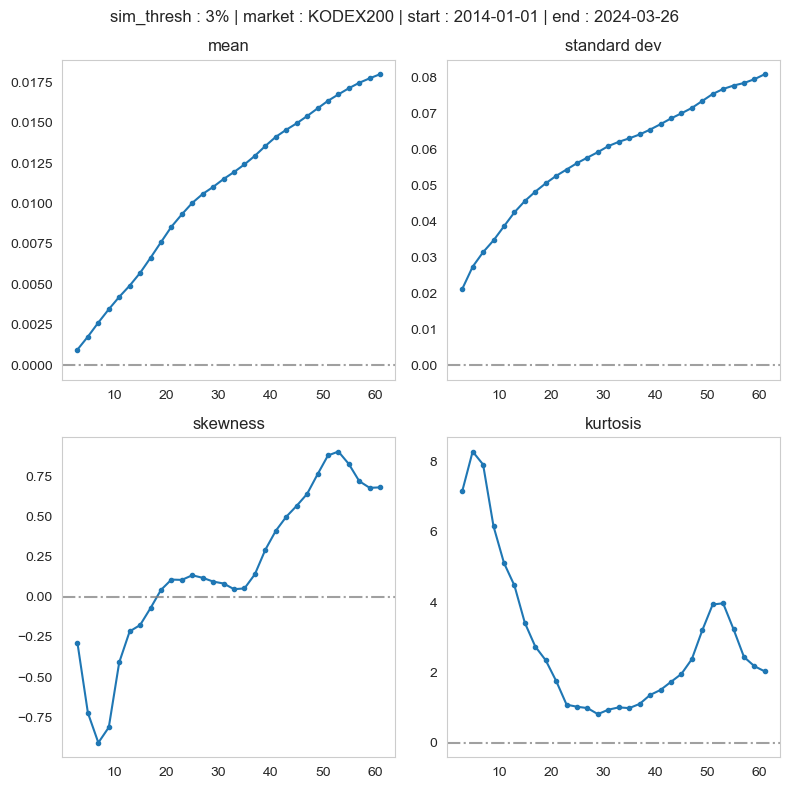

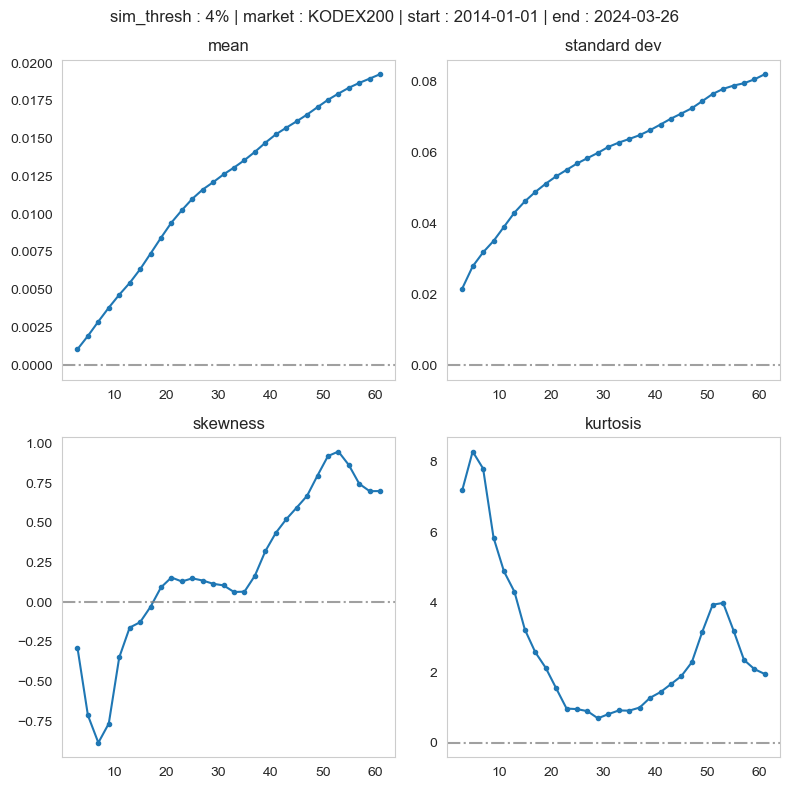

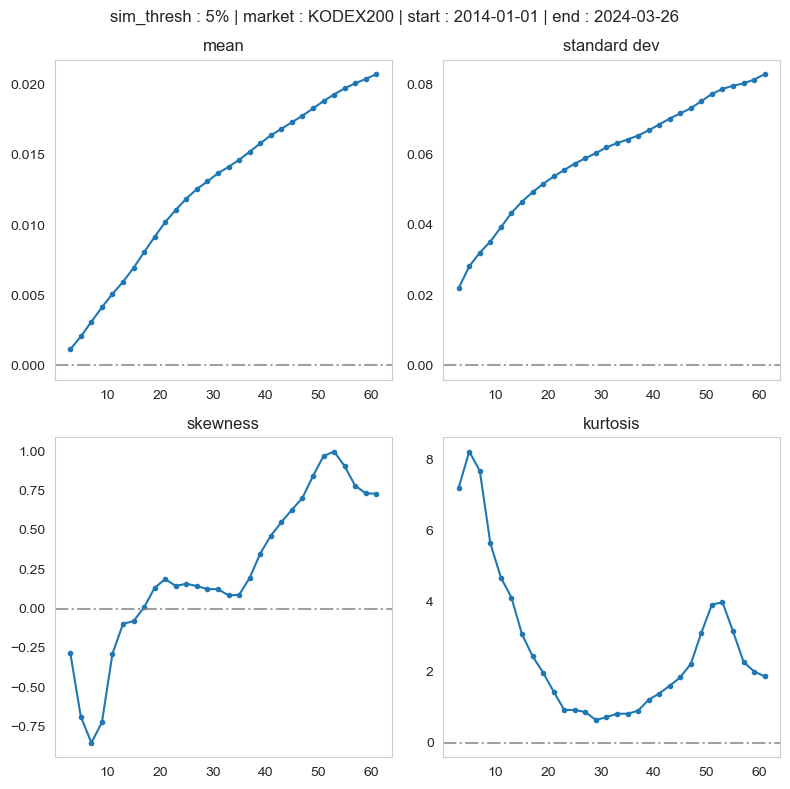

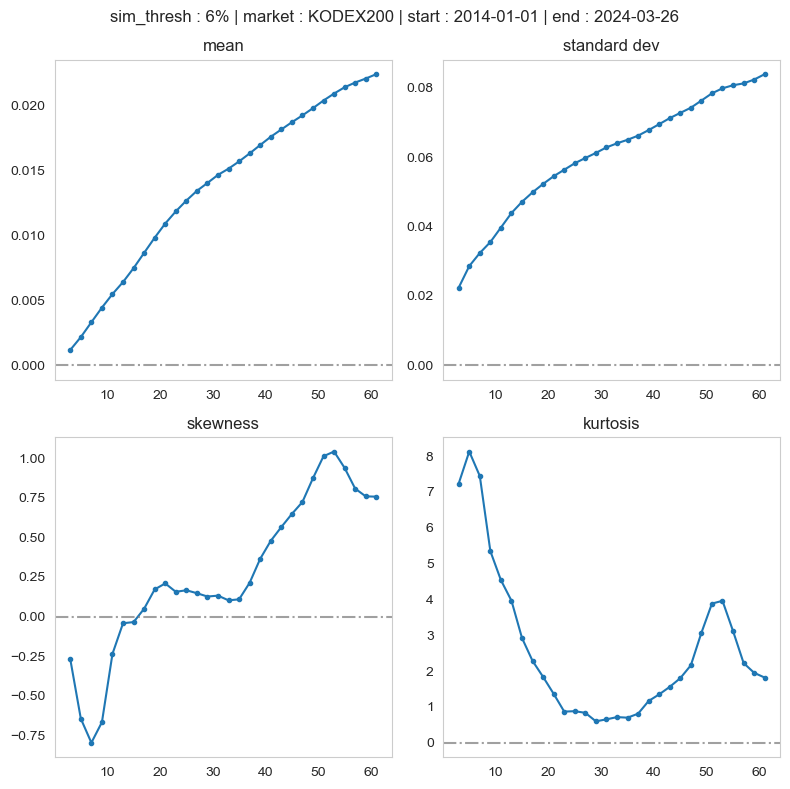

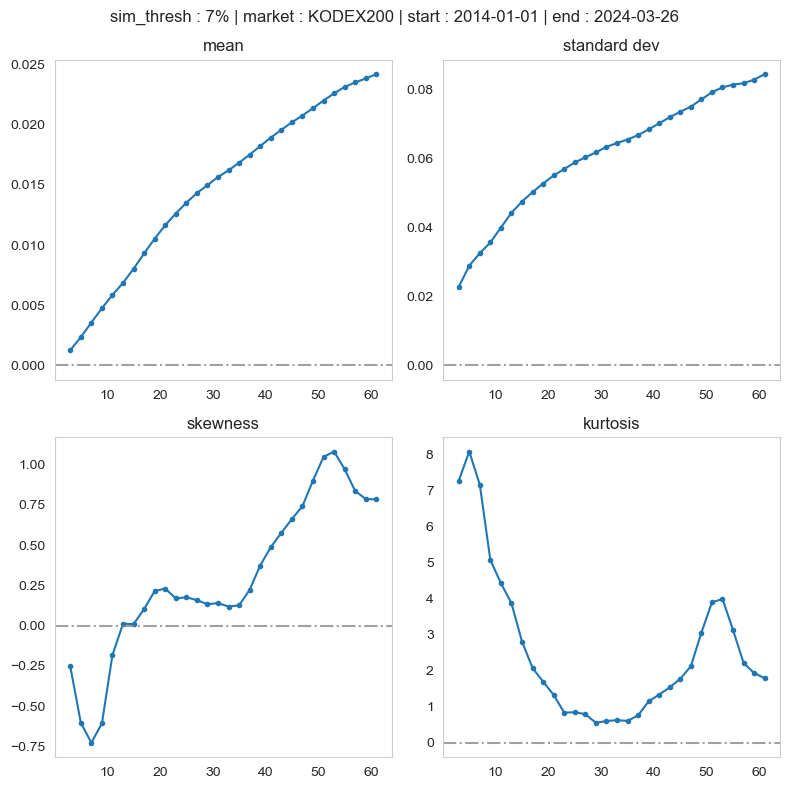

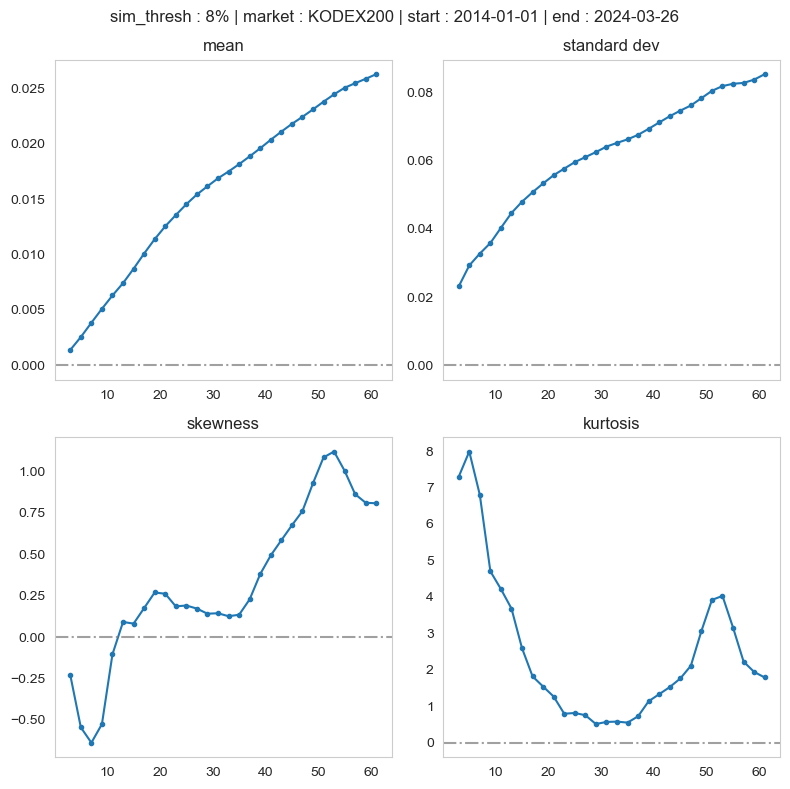

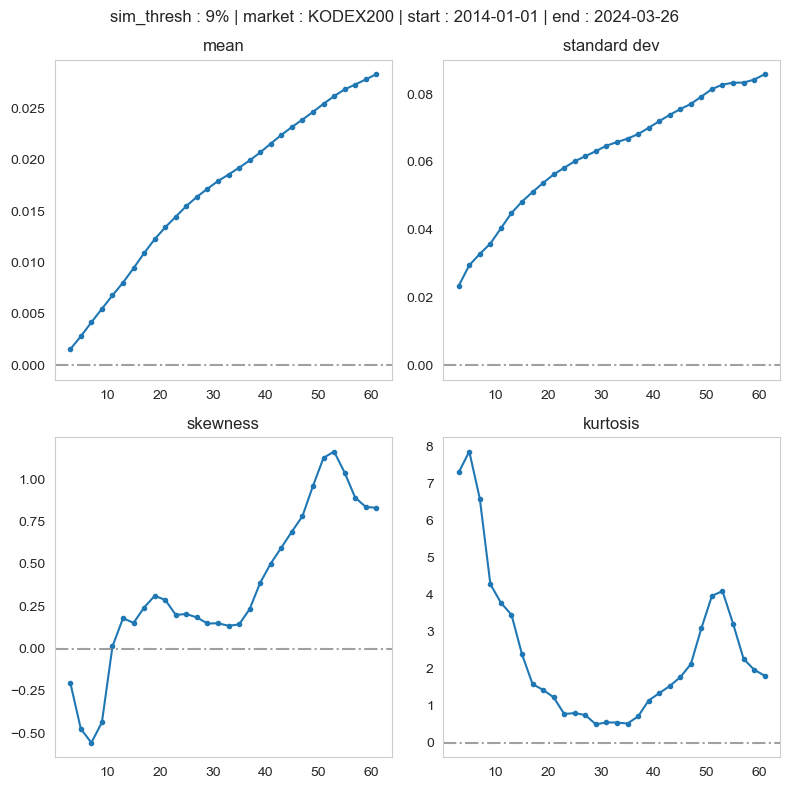

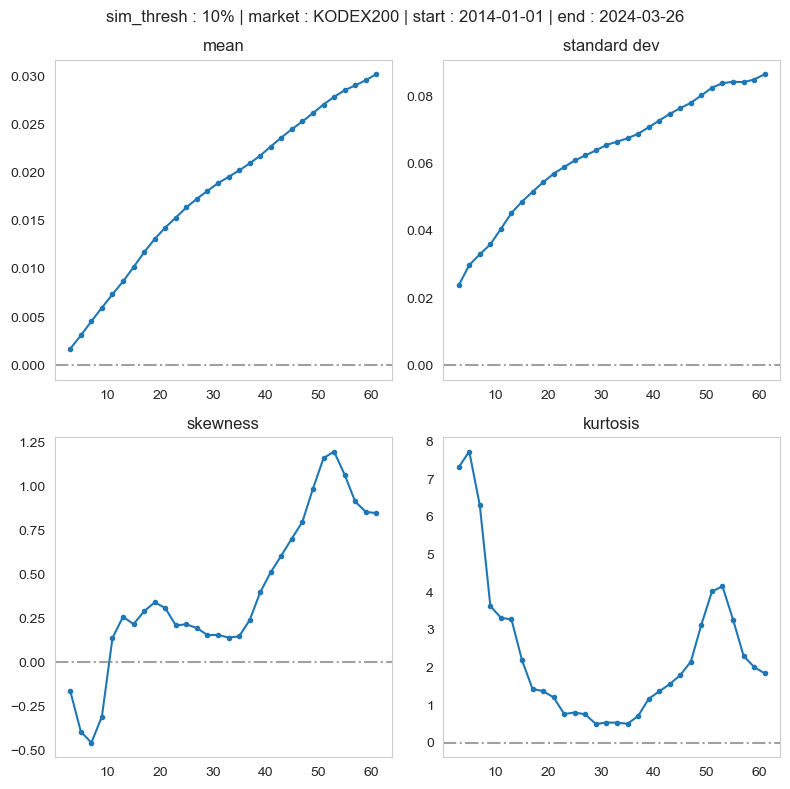

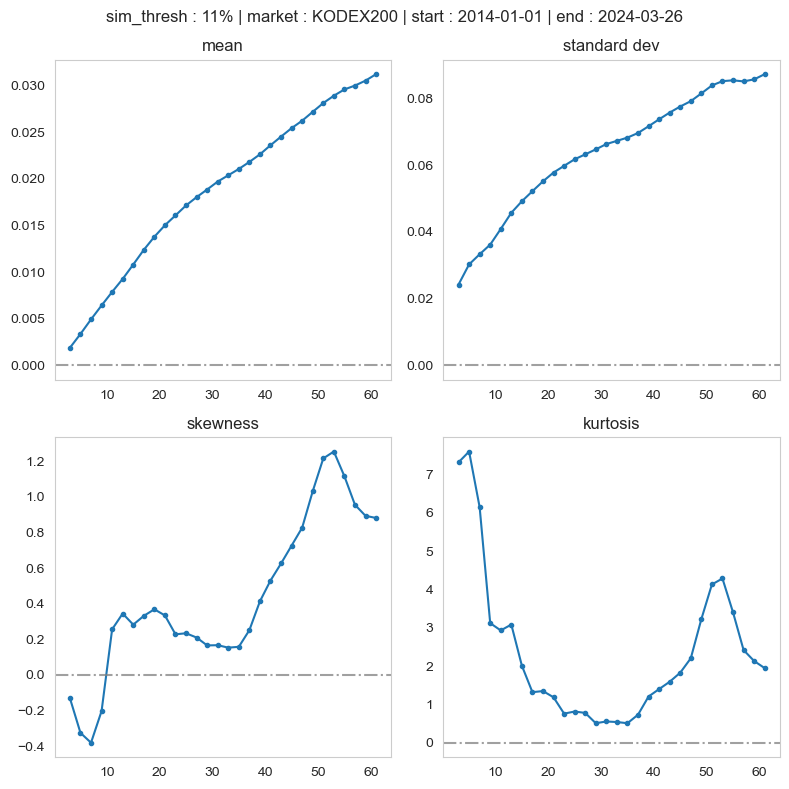

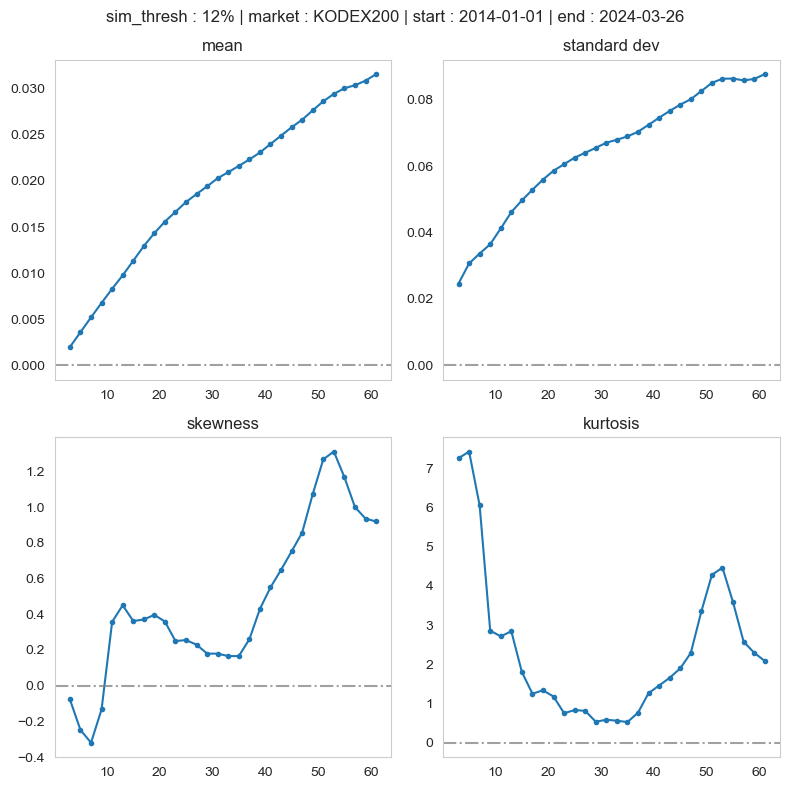

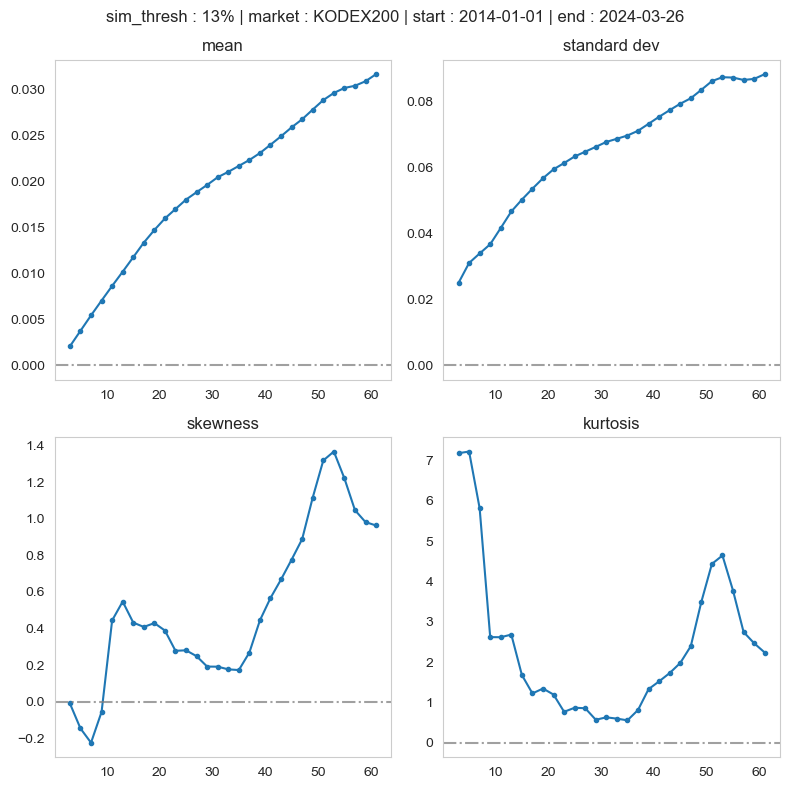

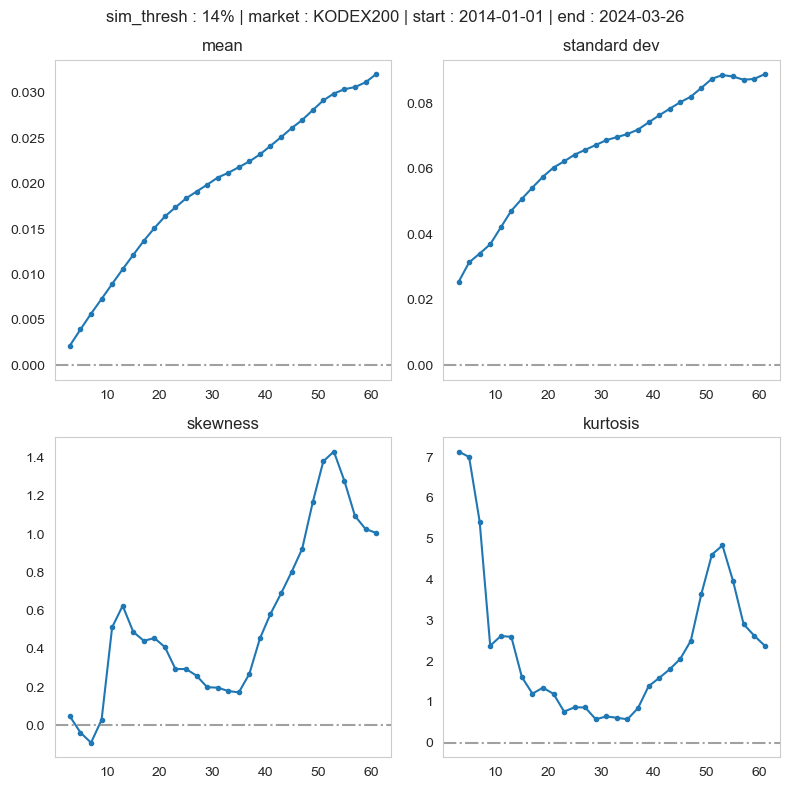

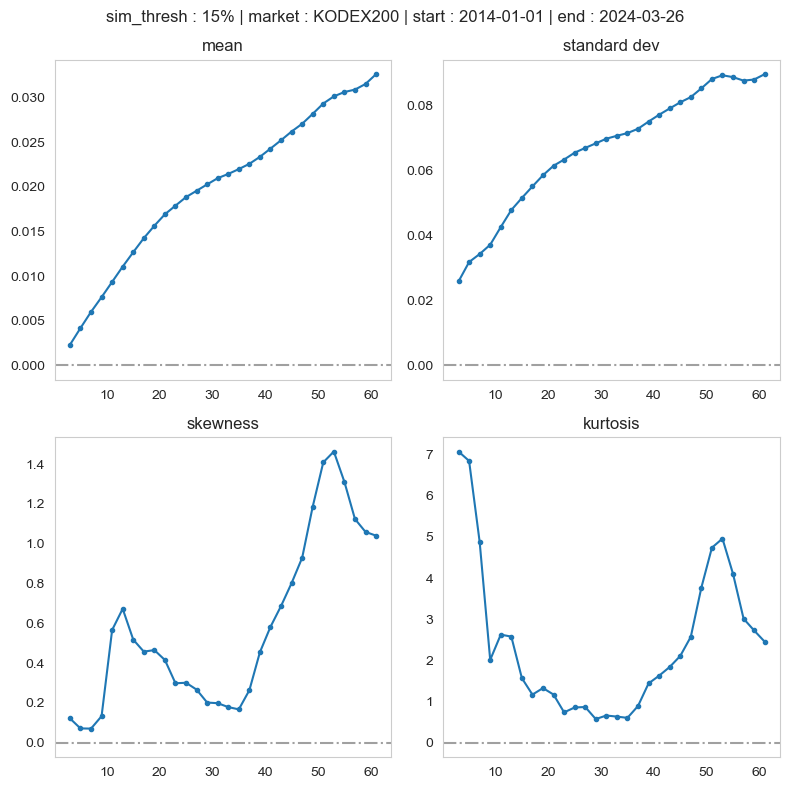

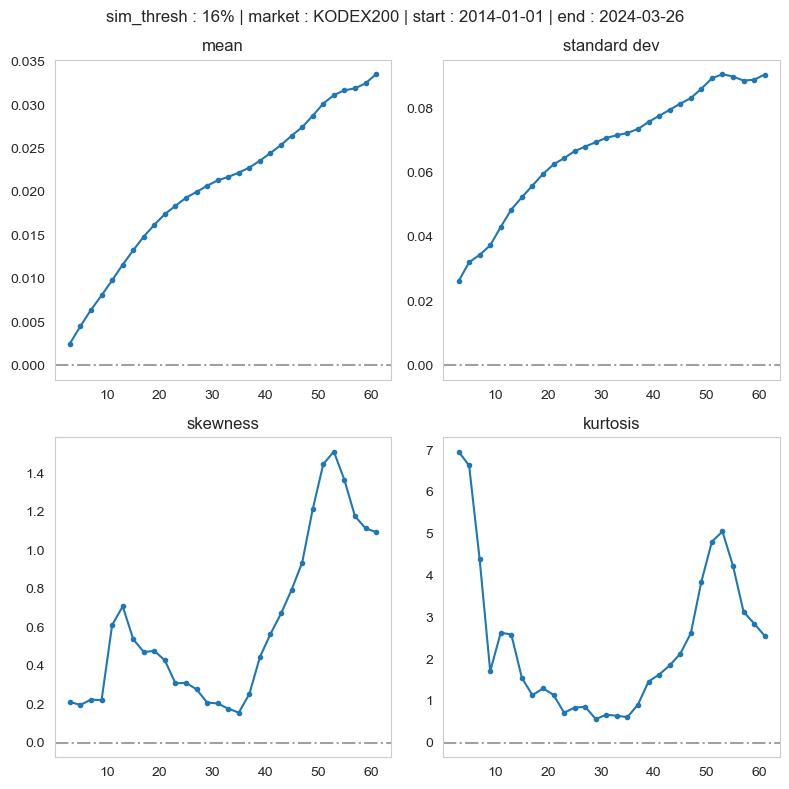

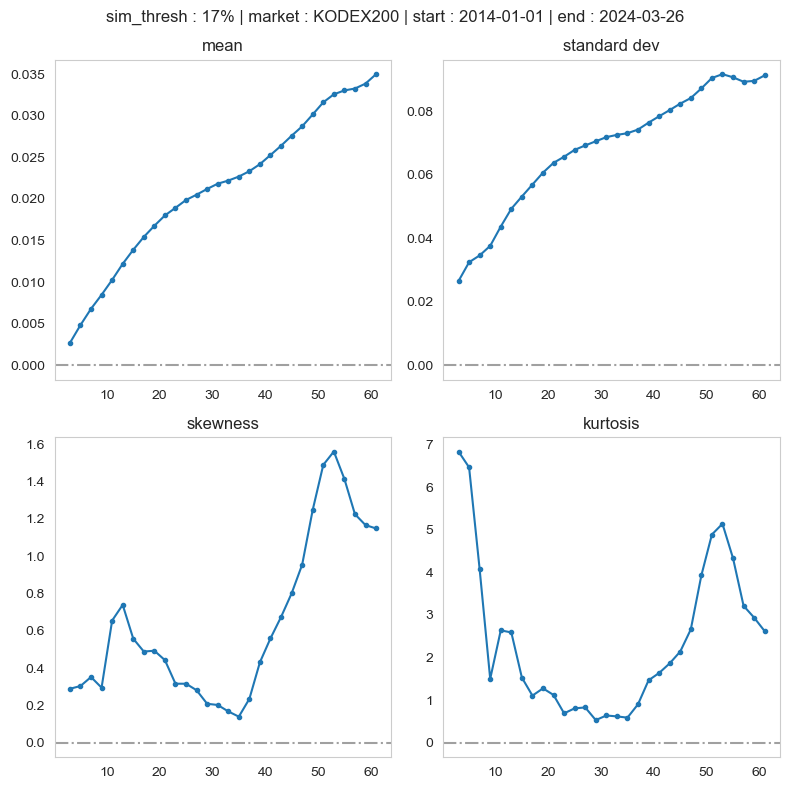

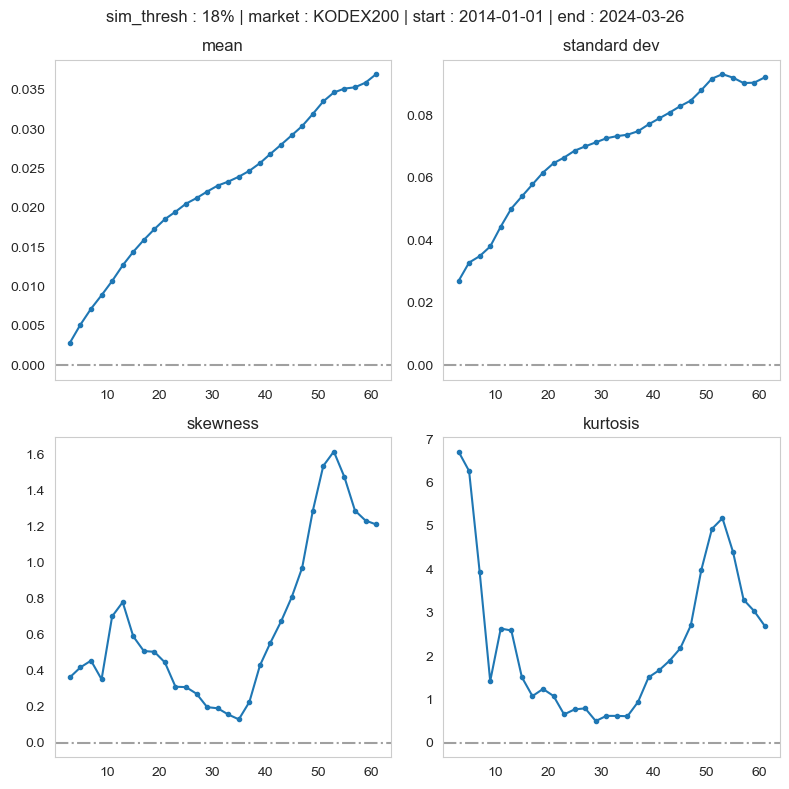

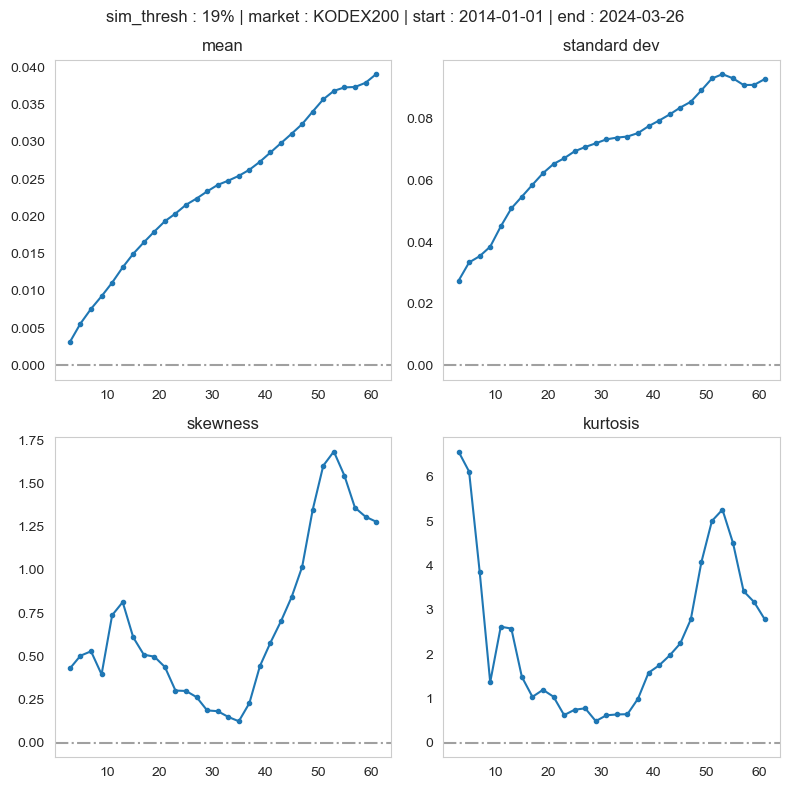

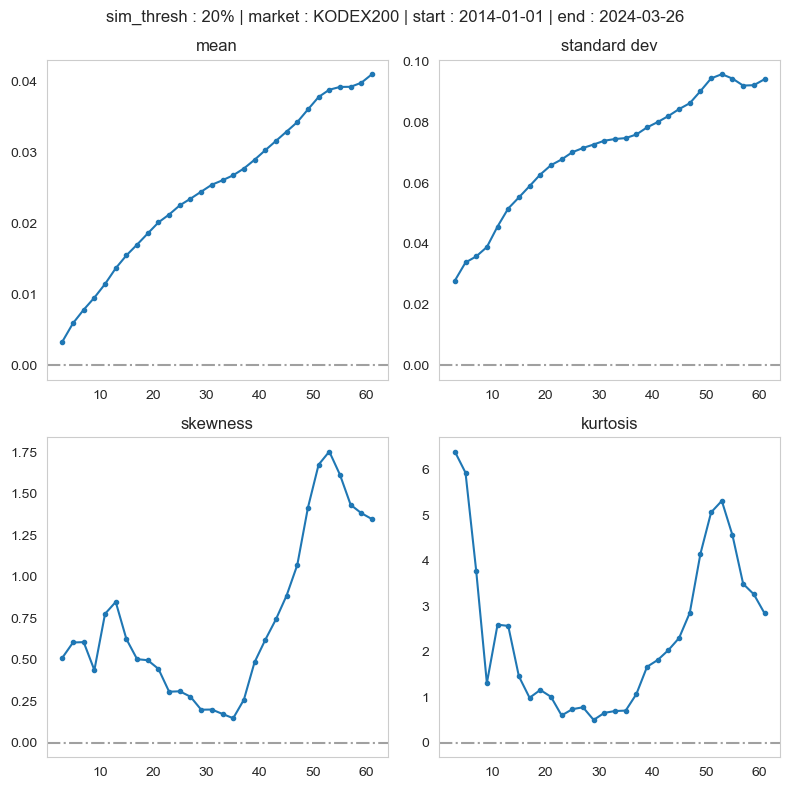

In [11]:
tick = 'KODEX200'
for i in threshold :
    t = -i * 100
    pipeline(int(t), days, dataframes, tick)

In [13]:
return_data

,-1days,-2days,-3days,-4days,-5days,-6days,-7days,-8days,-9days,-10days,...,-491days,-492days,-493days,-494days,-495days,-496days,-497days,-498days,-499days,-500days
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.009791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.002723,-0.007042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.003089,0.005803,-0.003931,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.000000,0.003089,0.005803,-0.003931,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2512,0.017293,0.005447,0.011710,-0.007217,0.001770,0.006400,0.014842,0.006536,0.020833,0.021514,...,0.041939,0.037500,0.045833,0.054412,0.044662,0.046732,0.060948,0.074782,0.066667,0.064978
2513,0.026382,0.043219,0.031685,0.037783,0.019356,0.028106,0.032613,0.040833,0.032746,0.046666,...,0.071006,0.067215,0.062893,0.071006,0.079358,0.069866,0.071881,0.085722,0.099191,0.091290
2514,-0.002925,0.023534,0.040420,0.028853,0.034969,0.016487,0.025263,0.029783,0.038027,0.029916,...,0.067624,0.068289,0.064486,0.060152,0.068289,0.076665,0.067145,0.069166,0.083047,0.096556
2515,-0.004005,-0.006942,0.019624,0.036577,0.024963,0.031104,0.012548,0.021359,0.025898,0.034174,...,0.059084,0.063890,0.064557,0.060740,0.056388,0.064557,0.072968,0.063409,0.065439,0.079375


In [15]:
data.Close

Date
2014-01-02    21452.0
2014-01-03    21244.0
2014-01-06    21302.0
2014-01-07    21368.0
2014-01-08    21368.0
               ...   
2024-03-20    36720.0
2024-03-21    37715.0
2024-03-22    37605.0
2024-03-25    37455.0
2024-03-26    37825.0
Name: Close, Length: 2517, dtype: float64

In [244]:
threshold_temp = round((data['Close']['2022-12'][-1] - data['Close']['2022-08'][0]) / data['Close']['2022-12'][-1], 3) # 0.09
print(threshold_temp)

-0.09


In [50]:
temp_mean = []
temp_median = []
temp_0 = []
temp_5 = []
temp_25 = []
temp_75 = []
temp_95 = []
temp_100 = []

for i in days :
    stat_temp = dataframes[f'day{i}_9.0per'].stack().reset_index()[0].quantile([0, 0.05, 0.25, 0.75, 0.95, 1.0]).T
    temp_mean.append(dataframes[f'day{i}_9.0per'].stack().reset_index()[0].mean())
    temp_median.append(dataframes[f'day{i}_9.0per'].stack().reset_index()[0].median())
    temp_0.append(dataframes[f'day{i}_9.0per'].stack().reset_index()[0].quantile([0, 0.05, 0.25, 0.75, 0.95, 1.0]).T[0.00])
    temp_5.append(dataframes[f'day{i}_9.0per'].stack().reset_index()[0].quantile([0, 0.05, 0.25, 0.75, 0.95, 1.0]).T[0.05])
    temp_25.append(dataframes[f'day{i}_9.0per'].stack().reset_index()[0].quantile([0, 0.05, 0.25, 0.75, 0.95, 1.0]).T[0.25])
    temp_75.append(dataframes[f'day{i}_9.0per'].stack().reset_index()[0].quantile([0, 0.05, 0.25, 0.75, 0.95, 1.0]).T[0.75])
    temp_95.append(dataframes[f'day{i}_9.0per'].stack().reset_index()[0].quantile([0, 0.05, 0.25, 0.75, 0.95, 1.0]).T[0.95])
    temp_100.append(dataframes[f'day{i}_9.0per'].stack().reset_index()[0].quantile([0, 0.05, 0.25, 0.75, 0.95, 1.0]).T[1.00])

<Axes: xlabel='Date'>

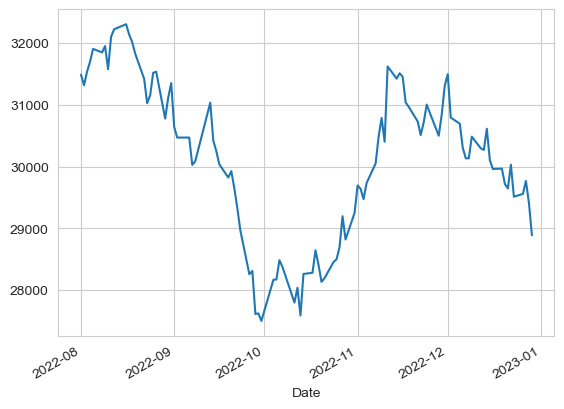

In [24]:
data['Close']['2022-08':'2022-12'].plot()

In [60]:
data['Close']['2022-12-29' : '2023-04'].index[[i for i in range(3, 63, 2)]]

DatetimeIndex(['2023-01-04', '2023-01-06', '2023-01-10', '2023-01-12',
               '2023-01-16', '2023-01-18', '2023-01-20', '2023-01-26',
               '2023-01-30', '2023-02-01', '2023-02-03', '2023-02-07',
               '2023-02-09', '2023-02-13', '2023-02-15', '2023-02-17',
               '2023-02-21', '2023-02-23', '2023-02-27', '2023-03-02',
               '2023-03-06', '2023-03-08', '2023-03-10', '2023-03-14',
               '2023-03-16', '2023-03-20', '2023-03-22', '2023-03-24',
               '2023-03-28', '2023-03-30'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [62]:
temp_dataframe = pd.DataFrame(
    [temp_0, temp_5, temp_25, temp_mean, temp_median, temp_75, temp_95, temp_100],
    columns = data['Close']['2022-12-29' : '2023-04'].index[[i for i in range(3, 63, 2)]],
    index = ['percentile0', 'percentile5', 'percentile25', 'percentile50', 'median', 'percentile75', 'percentile95', 'percentile100']
).T

In [63]:
temp_dataframe

,percentile0,percentile5,percentile25,percentile50,median,percentile75,percentile95,percentile100
Date,,,,,,,,
2023-01-04,-0.143792,-0.032157,-0.010668,0.001566,0.002313,0.013971,0.034932,0.133015
2023-01-06,-0.196191,-0.039889,-0.011071,0.002821,0.004827,0.019098,0.040604,0.153466
2023-01-10,-0.246389,-0.044357,-0.012671,0.004189,0.004146,0.023269,0.051588,0.169179
2023-01-12,-0.274049,-0.050239,-0.016527,0.005506,0.006011,0.026924,0.057644,0.150226
2023-01-16,-0.282297,-0.053279,-0.017352,0.006809,0.005763,0.032147,0.065865,0.214874
2023-01-18,-0.272520,-0.062467,-0.019115,0.008050,0.008031,0.034467,0.079763,0.231424
2023-01-20,-0.279597,-0.066455,-0.021349,0.009457,0.009592,0.038444,0.081061,0.232770
2023-01-26,-0.297473,-0.073122,-0.022448,0.010924,0.009825,0.042126,0.090264,0.226348
2023-01-30,-0.287903,-0.070988,-0.022549,0.012274,0.012026,0.046655,0.096167,0.248552


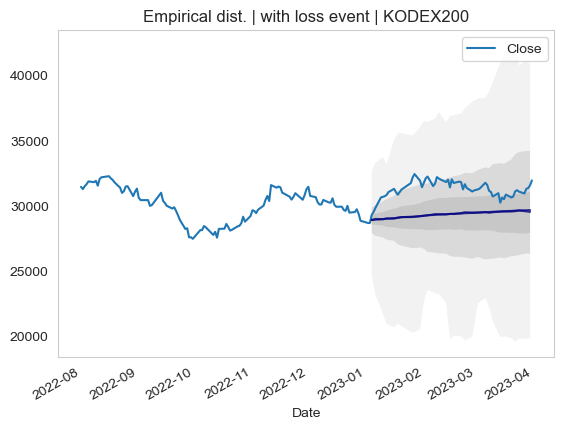

In [91]:
data['Close']['2022-08':'2023-03'].plot()
plt.plot((temp_dataframe * data['Close']['2022-12-29'] + data['Close']['2022-12-29'])[['percentile50','median']], color = 'navy', alpha = 0.75)
plt.fill_between(
    temp_dataframe.index, 
    (temp_dataframe * data['Close']['2022-12-29'] + data['Close']['2022-12-29'])['percentile25'], 
    (temp_dataframe * data['Close']['2022-12-29'] + data['Close']['2022-12-29'])['percentile75'], color = 'gray', alpha=0.2, edgecolor = 'none')
plt.fill_between(
    temp_dataframe.index, 
    (temp_dataframe * data['Close']['2022-12-29'] + data['Close']['2022-12-29'])['percentile5'], 
    (temp_dataframe * data['Close']['2022-12-29'] + data['Close']['2022-12-29'])['percentile95'], color = 'gray', alpha=0.2, edgecolor = 'none')
plt.fill_between(
    temp_dataframe.index, 
    (temp_dataframe * data['Close']['2022-12-29'] + data['Close']['2022-12-29'])['percentile0'], 
    (temp_dataframe * data['Close']['2022-12-29'] + data['Close']['2022-12-29'])['percentile100'], color = 'gray', alpha=0.1, edgecolor = 'none')
plt.legend()
plt.grid(False)
plt.title('Empirical dist. | with loss event | KODEX200')
plt.show()

In [82]:
return_data.iloc[:,2:61]

,-3days,-4days,-5days,-6days,-7days,-8days,-9days,-10days,-11days,-12days,...,-52days,-53days,-54days,-55days,-56days,-57days,-58days,-59days,-60days,-61days
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.003931,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.005803,-0.003931,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2512,0.011710,-0.007217,0.001770,0.006400,0.014842,0.006536,0.020833,0.021514,0.017974,0.010076,...,0.039188,0.011765,0.017729,0.033606,0.044199,0.048148,0.051144,0.044880,0.062936,0.063753
2513,0.031685,0.037783,0.019356,0.028106,0.032613,0.040833,0.032746,0.046666,0.047329,0.043882,...,0.072730,0.064537,0.037836,0.043643,0.059101,0.069415,0.073260,0.076177,0.070078,0.087657
2514,0.040420,0.028853,0.034969,0.016487,0.025263,0.029783,0.038027,0.029916,0.043877,0.044542,...,0.072677,0.070017,0.061800,0.035022,0.040846,0.056349,0.066693,0.070549,0.073474,0.067358
2515,0.019624,0.036577,0.024963,0.031104,0.012548,0.021359,0.025898,0.034174,0.026031,0.040048,...,0.072006,0.068963,0.066293,0.058043,0.031157,0.037004,0.052570,0.062956,0.066827,0.069764


In [85]:
temp_mean1 = []
temp_median1 = []
temp_01 = []
temp_51 = []
temp_251 = []
temp_751 = []
temp_951 = []
temp_1001 = []

for i in range(3,62,1) :
    stat_temp = return_data[f'-{i}days'].quantile([0, 0.05, 0.25, 0.75, 0.95, 1.0]).T
    temp_mean1.append(return_data[f'-{i}days'].mean())
    temp_median1.append(return_data[f'-{i}days'].median())
    temp_01.append(stat_temp[0.00])
    temp_51.append(stat_temp[0.05])
    temp_251.append(stat_temp[0.25])
    temp_751.append(stat_temp[0.75])
    temp_951.append(stat_temp[0.95])
    temp_1001.append(stat_temp[1.00])

In [257]:
temp_dataframe1 = pd.DataFrame(
    [temp_01, temp_51, temp_251, temp_mean1, temp_median1, temp_751, temp_951, temp_1001],
    columns = data['Close']['2022-12-29' : '2023-04'].index[[i for i in range(3, 62, 1)]],
    index = ['percentile0', 'percentile5', 'percentile25', 'percentile50', 'median', 'percentile75', 'percentile95', 'percentile100']
).T

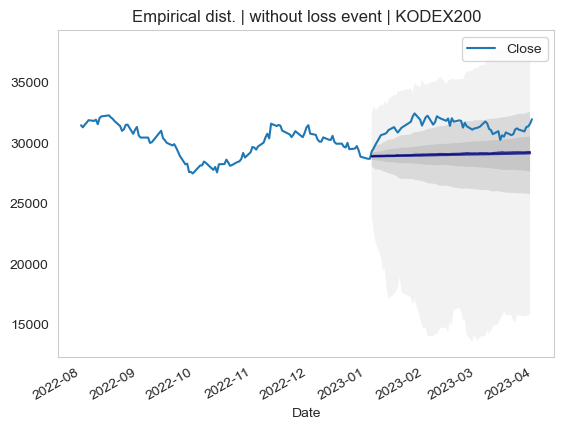

In [90]:
data['Close']['2022-08':'2023-03'].plot()
plt.plot((temp_dataframe1 * data['Close']['2022-12-29'] + data['Close']['2022-12-29'])[['percentile50','median']], color = 'navy', alpha = 0.75)
plt.fill_between(
    temp_dataframe1.index, 
    (temp_dataframe1 * data['Close']['2022-12-29'] + data['Close']['2022-12-29'])['percentile25'], 
    (temp_dataframe1 * data['Close']['2022-12-29'] + data['Close']['2022-12-29'])['percentile75'], color = 'gray', alpha=0.2, edgecolor = 'none')
plt.fill_between(
    temp_dataframe1.index, 
    (temp_dataframe1 * data['Close']['2022-12-29'] + data['Close']['2022-12-29'])['percentile5'], 
    (temp_dataframe1 * data['Close']['2022-12-29'] + data['Close']['2022-12-29'])['percentile95'], color = 'gray', alpha=0.2, edgecolor = 'none')
plt.fill_between(
    temp_dataframe1.index, 
    (temp_dataframe1 * data['Close']['2022-12-29'] + data['Close']['2022-12-29'])['percentile0'], 
    (temp_dataframe1 * data['Close']['2022-12-29'] + data['Close']['2022-12-29'])['percentile100'], color = 'gray', alpha=0.1, edgecolor = 'none')
plt.legend()
plt.grid(False)
plt.title('Empirical dist. | without loss event | KODEX200')
plt.show()

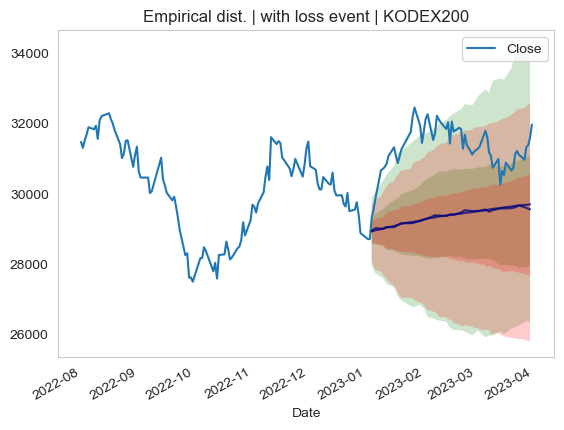

In [98]:
data['Close']['2022-08':'2023-03'].plot()
plt.plot((temp_dataframe * data['Close']['2022-12-29'] + data['Close']['2022-12-29'])[['percentile50','median']], color = 'navy', alpha = 0.75)
plt.fill_between(
    temp_dataframe.index, 
    (temp_dataframe * data['Close']['2022-12-29'] + data['Close']['2022-12-29'])['percentile25'], 
    (temp_dataframe * data['Close']['2022-12-29'] + data['Close']['2022-12-29'])['percentile75'], color = 'green', alpha=0.2, edgecolor = 'none')
plt.fill_between(
    temp_dataframe.index, 
    (temp_dataframe * data['Close']['2022-12-29'] + data['Close']['2022-12-29'])['percentile5'], 
    (temp_dataframe * data['Close']['2022-12-29'] + data['Close']['2022-12-29'])['percentile95'], color = 'green', alpha=0.2, edgecolor = 'none')
plt.fill_between(
    temp_dataframe1.index, 
    (temp_dataframe1 * data['Close']['2022-12-29'] + data['Close']['2022-12-29'])['percentile25'], 
    (temp_dataframe1 * data['Close']['2022-12-29'] + data['Close']['2022-12-29'])['percentile75'], color = 'red', alpha=0.2, edgecolor = 'none')
plt.fill_between(
    temp_dataframe1.index, 
    (temp_dataframe1 * data['Close']['2022-12-29'] + data['Close']['2022-12-29'])['percentile5'], 
    (temp_dataframe1 * data['Close']['2022-12-29'] + data['Close']['2022-12-29'])['percentile95'], color = 'red', alpha=0.2, edgecolor = 'none')
plt.legend()
plt.grid(False)
plt.title('Empirical dist. | with loss event | KODEX200')
plt.show()

test2

In [247]:
threshold_temp = round((data['Close']['2021-12'][-1] - data['Close']['2021-08'][0]) / data['Close']['2021-12'][-1], 2) # 0.09
print(threshold_temp)

-0.07


In [248]:
temp_mean = []
temp_median = []
temp_0 = []
temp_5 = []
temp_25 = []
temp_75 = []
temp_95 = []
temp_100 = []

for i in days :
    stat_temp = dataframes[f'day{i}_7.0per'].stack().reset_index()[0].quantile([0, 0.05, 0.25, 0.75, 0.95, 1.0]).T
    temp_mean.append(dataframes[f'day{i}_7.0per'].stack().reset_index()[0].mean())
    temp_median.append(dataframes[f'day{i}_7.0per'].stack().reset_index()[0].median())
    temp_0.append(dataframes[f'day{i}_7.0per'].stack().reset_index()[0].quantile([0, 0.05, 0.25, 0.75, 0.95, 1.0]).T[0.00])
    temp_5.append(dataframes[f'day{i}_7.0per'].stack().reset_index()[0].quantile([0, 0.05, 0.25, 0.75, 0.95, 1.0]).T[0.05])
    temp_25.append(dataframes[f'day{i}_7.0per'].stack().reset_index()[0].quantile([0, 0.05, 0.25, 0.75, 0.95, 1.0]).T[0.25])
    temp_75.append(dataframes[f'day{i}_7.0per'].stack().reset_index()[0].quantile([0, 0.05, 0.25, 0.75, 0.95, 1.0]).T[0.75])
    temp_95.append(dataframes[f'day{i}_7.0per'].stack().reset_index()[0].quantile([0, 0.05, 0.25, 0.75, 0.95, 1.0]).T[0.95])
    temp_100.append(dataframes[f'day{i}_7.0per'].stack().reset_index()[0].quantile([0, 0.05, 0.25, 0.75, 0.95, 1.0]).T[1.00])

In [254]:
temp_dataframe = pd.DataFrame(
    [temp_0, temp_5, temp_25, temp_mean, temp_median, temp_75, temp_95, temp_100],
    columns = data['Close']['2021-12-30' : '2023-04'].index[[i for i in range(3, 63, 2)]],
    index = ['percentile0', 'percentile5', 'percentile25', 'percentile50', 'median', 'percentile75', 'percentile95', 'percentile100']
).T

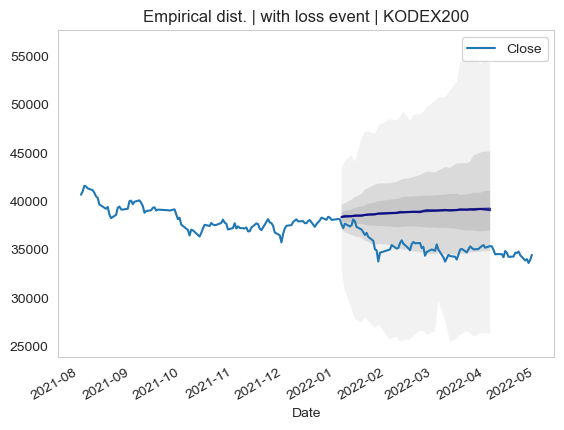

In [268]:
data['Close']['2021-08':'2022-04'].plot()
plt.plot((temp_dataframe * data['Close']['2021-12-29'] + data['Close']['2021-12-29'])[['percentile50','median']], color = 'navy', alpha = 0.75)
plt.fill_between(
    temp_dataframe.index, 
    (temp_dataframe * data['Close']['2021-12-29'] + data['Close']['2021-12-29'])['percentile25'], 
    (temp_dataframe * data['Close']['2021-12-29'] + data['Close']['2021-12-29'])['percentile75'], color = 'gray', alpha=0.2, edgecolor = 'none')
plt.fill_between(
    temp_dataframe.index, 
    (temp_dataframe * data['Close']['2021-12-29'] + data['Close']['2021-12-29'])['percentile5'], 
    (temp_dataframe * data['Close']['2021-12-29'] + data['Close']['2021-12-29'])['percentile95'], color = 'gray', alpha=0.2, edgecolor = 'none')
plt.fill_between(
    temp_dataframe.index, 
    (temp_dataframe * data['Close']['2021-12-29'] + data['Close']['2021-12-29'])['percentile0'], 
    (temp_dataframe * data['Close']['2021-12-29'] + data['Close']['2021-12-29'])['percentile100'], color = 'gray', alpha=0.1, edgecolor = 'none')
plt.legend()
plt.grid(False)
plt.title('Empirical dist. | with loss event | KODEX200')
plt.show()

In [258]:
temp_mean1 = []
temp_median1 = []
temp_01 = []
temp_51 = []
temp_251 = []
temp_751 = []
temp_951 = []
temp_1001 = []

for i in range(3,62,1) :
    stat_temp = return_data[f'-{i}days'].quantile([0, 0.05, 0.25, 0.75, 0.95, 1.0]).T
    temp_mean1.append(return_data[f'-{i}days'].mean())
    temp_median1.append(return_data[f'-{i}days'].median())
    temp_01.append(stat_temp[0.00])
    temp_51.append(stat_temp[0.05])
    temp_251.append(stat_temp[0.25])
    temp_751.append(stat_temp[0.75])
    temp_951.append(stat_temp[0.95])
    temp_1001.append(stat_temp[1.00])

In [262]:
temp_dataframe1 = pd.DataFrame(
    [temp_01, temp_51, temp_251, temp_mean1, temp_median1, temp_751, temp_951, temp_1001],
    columns = data['Close']['2021-12-29' : '2023-04'].index[[i for i in range(3, 62, 1)]],
    index = ['percentile0', 'percentile5', 'percentile25', 'percentile50', 'median', 'percentile75', 'percentile95', 'percentile100']
).T

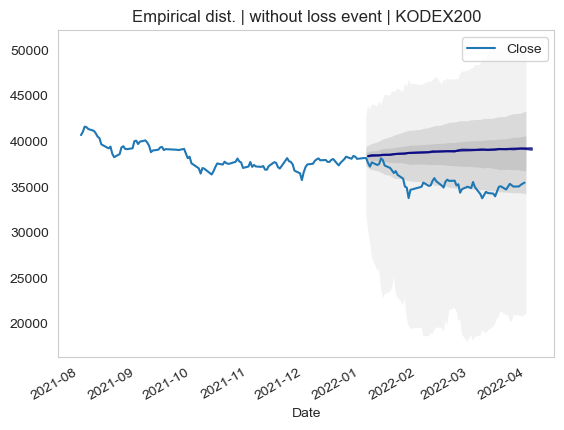

In [267]:
data['Close']['2021-08':'2022-03'].plot()
plt.plot((temp_dataframe * data['Close']['2021-12-29'] + data['Close']['2021-12-29'])[['percentile50','median']], color = 'navy', alpha = 0.75)
plt.fill_between(
    temp_dataframe1.index, 
    (temp_dataframe1 * data['Close']['2021-12-29'] + data['Close']['2021-12-29'])['percentile25'], 
    (temp_dataframe1 * data['Close']['2021-12-29'] + data['Close']['2021-12-29'])['percentile75'], color = 'gray', alpha=0.2, edgecolor = 'none')
plt.fill_between(
    temp_dataframe1.index, 
    (temp_dataframe1 * data['Close']['2021-12-29'] + data['Close']['2021-12-29'])['percentile5'], 
    (temp_dataframe1 * data['Close']['2021-12-29'] + data['Close']['2021-12-29'])['percentile95'], color = 'gray', alpha=0.2, edgecolor = 'none')
plt.fill_between(
    temp_dataframe1.index, 
    (temp_dataframe1 * data['Close']['2021-12-29'] + data['Close']['2021-12-29'])['percentile0'], 
    (temp_dataframe1 * data['Close']['2021-12-29'] + data['Close']['2021-12-29'])['percentile100'], color = 'gray', alpha=0.1, edgecolor = 'none')
plt.legend()
plt.grid(False)
plt.title('Empirical dist. | without loss event | KODEX200')
plt.show()

test3

In [271]:
test_start = '2022-01'
test_end = '2022-06'

threshold_temp = round((data['Close'][test_end][-1] - data['Close'][test_start][0]) / data['Close'][test_end][-1], 2) # 0.09
print(threshold_temp)

-0.27


In [280]:
temp_mean = []
temp_median = []
temp_0 = []
temp_5 = []
temp_25 = []
temp_75 = []
temp_95 = []
temp_100 = []

for i in days :
    stat_temp = dataframes[f'day{i}_20.0per'].stack().reset_index()[0].quantile([0, 0.05, 0.25, 0.75, 0.95, 1.0]).T
    temp_mean.append(dataframes[f'day{i}_20.0per'].stack().reset_index()[0].mean())
    temp_median.append(dataframes[f'day{i}_20.0per'].stack().reset_index()[0].median())
    temp_0.append(stat_temp[0.00])
    temp_5.append(stat_temp[0.05])
    temp_25.append(stat_temp[0.25])
    temp_75.append(stat_temp[0.75])
    temp_95.append(stat_temp[0.95])
    temp_100.append(stat_temp[1.00])

In [281]:
temp_dataframe = pd.DataFrame(
    [temp_0, temp_5, temp_25, temp_mean, temp_median, temp_75, temp_95, temp_100],
    columns = data['Close'][test_end : ].index[[i for i in range(3, 63, 2)]],
    index = ['percentile0', 'percentile5', 'percentile25', 'percentile50', 'median', 'percentile75', 'percentile95', 'percentile100']
).T

In [282]:
temp_dataframe

,percentile0,percentile5,percentile25,percentile50,median,percentile75,percentile95,percentile100
Date,,,,,,,,
2022-06-08,-0.143792,-0.034610,-0.012258,0.003338,0.003766,0.015662,0.040282,0.133015
2022-06-10,-0.196191,-0.042200,-0.010581,0.005937,0.005786,0.020609,0.063463,0.153466
2022-06-14,-0.185241,-0.042144,-0.012000,0.007839,0.005528,0.026710,0.063517,0.169179
2022-06-16,-0.139499,-0.045947,-0.017863,0.009539,0.007704,0.032024,0.068261,0.150226
2022-06-20,-0.116196,-0.052068,-0.019609,0.011461,0.007691,0.036879,0.082530,0.214874
2022-06-22,-0.130740,-0.064246,-0.021632,0.013678,0.011723,0.042147,0.092005,0.231424
2022-06-24,-0.135415,-0.070824,-0.023827,0.015495,0.016758,0.046562,0.106453,0.232770
2022-06-28,-0.120665,-0.080391,-0.026422,0.017010,0.020117,0.050736,0.112945,0.226348
2022-06-30,-0.133049,-0.076013,-0.026880,0.018582,0.019445,0.059350,0.109944,0.248552


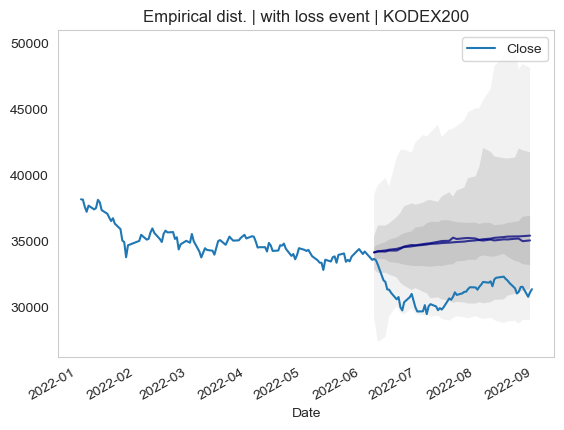

In [287]:
data['Close'][test_start:'2022-08'].plot()
plt.plot((temp_dataframe * data['Close'][test_end:][0] + data['Close'][test_end:][0])[['percentile50','median']], color = 'navy', alpha = 0.75)
plt.fill_between(
    temp_dataframe.index, 
    (temp_dataframe * data['Close'][test_end:][0] + data['Close'][test_end:][0])['percentile25'], 
    (temp_dataframe * data['Close'][test_end:][0] + data['Close'][test_end:][0])['percentile75'], color = 'gray', alpha=0.2, edgecolor = 'none')
plt.fill_between(
    temp_dataframe.index, 
    (temp_dataframe * data['Close'][test_end:][0] + data['Close'][test_end:][0])['percentile5'], 
    (temp_dataframe * data['Close'][test_end:][0] + data['Close'][test_end:][0])['percentile95'], color = 'gray', alpha=0.2, edgecolor = 'none')
plt.fill_between(
    temp_dataframe.index, 
    (temp_dataframe * data['Close'][test_end:][0] + data['Close'][test_end:][0])['percentile0'], 
    (temp_dataframe * data['Close'][test_end:][0] + data['Close'][test_end:][0])['percentile100'], color = 'gray', alpha=0.1, edgecolor = 'none')
plt.legend()
plt.grid(False)
plt.title('Empirical dist. | with loss event | KODEX200')
plt.show()